In [57]:
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
def sep_two_classes(Y, num_class):
    Y = Y.copy()
    for i in range(Y.shape[0]):
        if Y[i] == num_class:
            Y[i] = 1
        else:
            Y[i] = -1
    return Y

In [4]:
def h(theta, X):
    return 1.0 / (1 + np.exp(-np.dot(X, theta)))

In [5]:
def weak_clssefier(X, weights):
    Z = h(weights, X)
    return Z

In [54]:
def train_clf(X, Y, weights):
    newY = np.asarray([y if y == 1 else 0 for y in Y])
    P = np.asarray(h(weights, X))
    L = 0
    _accuracy = 0
    alpha = 0.001
    t = 0
    while t < 10:
        for i in range(len(weights)):
            weights[i] -= alpha * sum([(P[j] - newY[j])*X[j][i] for j in range(len(P))])
        P = h(weights, X)
        _accuracy = accuracy(newY, [0 if p < 0.5 else 1 for p in P])
        alpha = max(0.0001, alpha*0.9)
        if _accuracy > 0.5:
            return weights
        t+=1
    return weights

In [7]:
def Q(X, Y, W, weights_for_weak_clf):
    Qsum = 0
    for i in range(X.shape[0]):
        p = -1 if weak_clssefier(X[i], weights_for_weak_clf) < 0.5 else 1
        I = 1 if (Y[i]*p) < 0 else 0
        Qsum += W[i] * I
    return Qsum

In [8]:
def alpha(Q):
    return 0.5 * np.log((1-Q)/Q)

In [97]:
def fit(X, Y, num_weak_clf, T):
    #1 инициализация весов объектов
    P = np.asarray([1/X.shape[0] for i in range(X.shape[0])])
    alphas = []
    bs = []
    #2 Для всех t=1,...,T, пока не выполнен критерий останова.
    while len(alphas) < num_weak_clf:
        weights_for_weak_cls = np.random.rand(T, X.shape[1])#инициализируем матрицу с весами для слабых классификаторов,
                        #выберем тот, у которого самые хорошие веса
        #print('WFCLS', weights_for_weak_cls)
        #2.1 Находим классификатор b_t: X->{-1,+1} который минимизирует взвешенную ошибку классификации;
        #b_t = argmin_b Q(b,W^l);
        for wfwc in weights_for_weak_cls:
            wfwc = train_clf(X, Y, wfwc)
        Qs = []
        for wfwc in weights_for_weak_cls:
            Qs.append(Q(X, Y, P, wfwc))
        Qs = np.asarray(Qs)
        argmin = np.argmin(Qs)
        if Qs[argmin]> 0.5:
            pass
        else:
            b_t_weights = weights_for_weak_cls[argmin]
            bs.append(b_t_weights)
            #2.2 Пересчитываем кооэффициент взвешенного голосования для алгоритма классификации b_t:

            alpha_t = alpha(Qs[argmin])
            alphas.append(alpha_t)

            #2.3 Пересчет весов объектов: w_i = w_i*exp(-alpha_t*y_i*b_t(x_i)), i = 1,...,l
            for i in range(P.shape[0]):
                p = -1 if weak_clssefier(X[i], b_t_weights) < 0.5 else 1
                P[i] *= np.exp(-alpha_t*Y[i]*p)

            #2.4 Нормировка весов объектов:

            P0 = np.sum(P)
            for p in P:
                p/=P0
    return np.asarray(alphas), np.asarray(bs)
        

In [10]:
def predict(X, alphas, weak_clf_weights):
    tmp_sum = 0
    for t in range(alphas.shape[0]):
        p = -1 if weak_clssefier(X, weak_clf_weights[t]) < 0.5 else 1
        tmp_sum += alphas[t] * p
    return (np.sign(tmp_sum), tmp_sum)

In [11]:
def accuracy(y_true, y_pred):
    counter = 0
    for i in range(len(y_true)):
        if y_true[i] == y_pred[i]:
            counter +=1
    return counter/len(y_true)

In [78]:
def plot_progress(X, Y, alphas, bs):
    progress = [0,]
    for i in range(0, len(alphas[0])):
        ttl = []
        for x in X:
            pr0 = predict(x, alphas[0][0:i], bs[0][0:i, :])
            pr1 = predict(x, alphas[1][0:i], bs[1][0:i, :])
            pr2 = predict(x, alphas[2][0:i], bs[2][0:i, :])
            ttl.append(np.argmax(np.asarray([pr0[1], pr1[1], pr2[1]])))
        progress.append(accuracy(Y, ttl))
    plt.plot(progress)
    plt.yticks(np.arange(0, 1.0, 0.1))
    plt.show()

In [13]:
iris = datasets.load_iris()
X, Y = iris.data, iris.target
p=np.random.permutation(X.shape[0])
x_train = X[p[0:int(len(X)*0.7)], :]
y_train = Y[p[0:int(len(Y)*0.7)]]
x_test = X[p[int(len(X)*0.7):], :]
y_test = Y[p[int(len(Y)*0.7):]]
x_train = (x_train - np.mean(x_train, axis = 0)) / np.var(x_train, axis = 0)
x_test = (x_test - np.mean(x_test, axis = 0)) / np.var(x_test, axis = 0)

y_train0 = sep_two_classes(y_train, 0)
y_train1 = sep_two_classes(y_train, 1)
y_train2 = sep_two_classes(y_train, 2)

y_test0 = sep_two_classes(y_test, 0)
y_test1 = sep_two_classes(y_test, 1)
y_test2 = sep_two_classes(y_test, 2)




----------------------------------------------
--- 1.4131762981414795 seconds ---


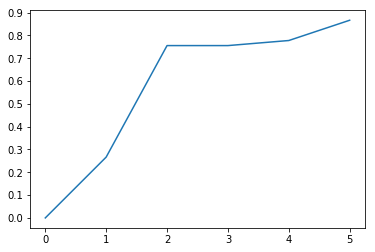

accurecy: 5 weak clfs 
 0:|0.5555555555555556| 
 1:|0.4222222222222222| 
 2:|0.8666666666666667| 
 total:|0.8666666666666667| 



In [98]:
accuracys0 = np.asarray([])
accuracys1 = np.asarray([])
accuracys2 = np.asarray([])
total_accs = np.asarray([])
np.random.seed(0)
num_wclfs = 5
print('\n\n\n----------------------------------------------')
start_time = time.time()
alphas0, bs0 = fit(x_train, y_train0, num_wclfs, 15)
alphas1, bs1 = fit(x_train, y_train1, num_wclfs, 15)
alphas2, bs2 = fit(x_train, y_train2, num_wclfs, 15)
print("--- %s seconds ---" % (time.time() - start_time))

plot_progress(x_test, y_test, [alphas0, alphas1, alphas2], [bs0, bs1, bs2])
y_predicted0 = []
y_predicted1 = []
y_predicted2 = []
total_pr = []
for x in x_test:
    pr0 = predict(x, alphas0, bs0)
    pr1 = predict(x, alphas1, bs1)
    pr2 = predict(x, alphas2, bs2)
    y_predicted0.append(pr0[0])
    y_predicted1.append(pr1[0])
    y_predicted2.append(pr2[0])
    total_pr.append(np.argmax(np.asarray([pr0[1], pr1[1], pr2[1]])))

y_predicted0 = np.asarray(y_predicted0)
y_predicted1 = np.asarray(y_predicted1)
y_predicted2 = np.asarray(y_predicted2)
total_pr = np.asarray(total_pr)

acc0 = accuracy(y_test0, y_predicted0)
acc1 = accuracy(y_test1, y_predicted1)
acc2 = accuracy(y_test2, y_predicted2)
total_acc = accuracy(y_test, total_pr)

np.append(accuracys0, acc0)
np.append(accuracys1, acc1)
np.append(accuracys2, acc2)
np.append(total_accs, total_acc)
print('accurecy: {T} weak clfs'.format(T=num_wclfs), '\n 0:|{acc0}| \n 1:|{acc1}| \n 2:|{acc2}| \n total:|{total_acc}| \n'.format(acc0=acc0, acc1=acc1, acc2=acc2, total_acc=total_acc))